# Next steps for automated scoring
I need to change the system prompt in order to get the LLM's answer to adapt to my scoring instead of the other way around (so no .split().strip() because the format will be different from LLM to LLM).

I am taking too many "opinionated" decisions where I make a certain hypothesis, but we don't actually know whether it's true, so we need to measure against a baseline without those hypotheses (like 5% tolerance for example, could work, but could be terribly wrong...)

In [38]:
import os
from openai import OpenAI
from IPython.display import Markdown, display

api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=api_key, project="proj_XBK3SmQEgnxzAc3W3OPTIYZs")

# Function to display markdown text
def print_md(text):
    display(Markdown(text))

In [39]:
import pandas as pd
target = pd.read_csv('target/target_digit_integer_V3', sep=';')
exampleTargetDF = pd.read_csv('target/exampleTarget_digit_integer_V3', sep=';')

In [44]:
exampleTargetDF['Target Scenario1integer'][0]

'11'

In [40]:
exampleTargetDF

,examplePrompt,Complexité,Target Scenario1integer,Target Scenario2integer,Target Scenario3integer,Target Scenario4integer,Target Scenario5integer,Target Scenario6integer
0,What's the average basket in France?,1,11,11,11,15,10,9
1,Which country has the highest turnover?,2,Italy,Spain,Italy,Spain,Italy,France
2,List the country names in descending order per...,2,"Italy, France, Spain","Italy, Spain, France","Italy, Spain, France","Spain, Italy, France","France, Spain, Italy","France, Spain, Italy"
3,Does France have a higher generated turnover t...,2,No,No,No,Yes,No,Yes
4,What is the average number of units sold acros...,3,3.67,55.67,533.0,5845.33,48776.33,524579.67


In [41]:
def query_model(messages):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0, 
        max_tokens=50
    )
    return completion.choices[0].message.content

In [42]:
# Optimal Prompts V3
systemPromptV3 = f"""
You are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:
- For numeric values, provide integers whenever possible, or round to two decimal places using a period (.) for decimals.
- For list or ranking requests, format the answer as a comma (,) seperated list, e.g., 'Spain, France, Italy'.
- For yes/no questions, respond with 'Yes' or 'No' only.
- Assume all questions are data-driven and require precise, direct responses based on the provided data.

Here is the table:
###
"""

In [66]:
# Enhanced system prompt to emphasize the use of digits for numbers
systemPromptV3 = f"""
You are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:
- For numeric values, provide answers using digits (e.g., '4' instead of 'four'), and round to two decimal places using a period (.) for decimals when necessary.
- For list or ranking requests, format the answer as a comma-separated list, e.g., 'Spain, France, Italy'.
- For yes/no questions, respond with 'Yes' or 'No' only.
- Assume all questions are data-driven and require precise, direct responses based on the provided data.

Here is the table:
###
"""

In [51]:
exampleTargetDF

,examplePrompt,Complexité,Target Scenario1integer,Target Scenario2integer,Target Scenario3integer,Target Scenario4integer,Target Scenario5integer,Target Scenario6integer
0,What's the average basket in France?,1,11,11,11,15,10,9
1,Which country has the highest turnover?,2,Italy,Spain,Italy,Spain,Italy,France
2,List the country names in descending order per...,2,"Italy, France, Spain","Italy, Spain, France","Italy, Spain, France","Spain, Italy, France","France, Spain, Italy","France, Spain, Italy"
3,Does France have a higher generated turnover t...,2,No,No,No,Yes,No,Yes
4,What is the average number of units sold acros...,3,3.67,55.67,533.0,5845.33,48776.33,524579.67


Example message to help calculate tokens for each request:

MESSAGES:  [{'role': 'system', 'content': "\nYou are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:\n- For numeric values, provide integers whenever possible, or round to two decimal places using a period (.) for decimals.\n- For list or ranking requests, format the answer as a comma (,) seperated list, e.g., 'Spain, France, Italy'.\n- For yes/no questions, respond with 'Yes' or 'No' only.\n- Assume all questions are data-driven and require precise, direct responses based on the provided data.\n\nHere is the table:\n###\n        units_sold  purchasers  generated_turnover  average_basket\nFrance         407         373                4216              11\nSpain          544         398                5705              14\nItaly          648         482                6347              14"}, {'role': 'user', 'content': "What's the average basket in France?"}, {'role': 'assistant', 'content': '11'}, {'role': 'user', 'content': 'Which country has the highest turnover?'}, {'role': 'assistant', 'content': 'Italy'}, {'role': 'user', 'content': 'List the country names in descending order per number of purchasers?'}, {'role': 'assistant', 'content': 'Italy, Spain, France'}, {'role': 'user', 'content': 'Does France have a higher generated turnover than Italy?'}, {'role': 'assistant', 'content': 'No'}, {'role': 'user', 'content': 'What is the average number of units sold across all countries?'}, {'role': 'assistant', 'content': '533.0'}, {'role': 'user', 'content': 'How many clients are there in France?'}]

In [67]:
# Import TXT
directory = "data/multiTXT_integers_V3/"
files = os.listdir(directory)

# Define the DataFrame to store LLM responses
LLMresponse_columns = ["Prompt"] + [f"Response {scenario}" for scenario in files]
LLMresponse = pd.DataFrame(columns=LLMresponse_columns)

for idx, prompt_row in target.iterrows():   # could also do: prompt = target.at[j, 'Prompt'] instead of iterrows() if i don't compare to target straight after
    #if idx == 1:  # Stop after processing the first prompt
    #    break
    prompt = prompt_row['Prompt']
    responses = [prompt]  # start each row with the prompt

    for fileName in files:
        with open(os.path.join(directory, fileName), 'r', encoding='utf-8') as file:
            loaded_string = file.read()         # est-ce que ça risque de fortement ralentir la boucle ? Comparé à avoir cette donnée en mémoire
        messages=[{"role": "system", "content": systemPromptV3 + loaded_string},
            # Example question and answer to set the pattern
            {"role": "user", "content": exampleTargetDF["examplePrompt"][0]},   #What's the average basket in France?
            {"role": "assistant", "content": exampleTargetDF[f"Target {fileName.replace('.txt', '')}"][0]},
            {"role": "user", "content": exampleTargetDF["examplePrompt"][1]},   #Which country has the highest turnover?
            {"role": "assistant", "content": exampleTargetDF[f"Target {fileName.replace('.txt', '')}"][1]},
            {"role": "user", "content": exampleTargetDF["examplePrompt"][2]},   #List the country names in descending order per number of purchasers?
            {"role": "assistant", "content": exampleTargetDF[f"Target {fileName.replace('.txt', '')}"][2]},
            {"role": "user", "content": exampleTargetDF["examplePrompt"][3]},   #Does France have a higher generated turnover than Italy?
            {"role": "assistant", "content": exampleTargetDF[f"Target {fileName.replace('.txt', '')}"][3]},
            {"role": "user", "content": exampleTargetDF["examplePrompt"][4]},   #What is the average number of units sold across all countries?
            {"role": "assistant", "content": exampleTargetDF[f"Target {fileName.replace('.txt', '')}"][4]},

            # Actual user question
            {"role": "user", "content": prompt}]
        response_content = query_model(messages)
        # Store response for each table variation (though generated only once in previous example)
        responses.append(response_content) # CAREFUL, make sure the messages received are IN THE SAME ORDER as the prompts.

    # Append to DataFrame
    LLMresponse.loc[len(LLMresponse)] = responses

# Optionally, print or inspect the LLMresponse DataFrame
LLMresponse.head()

,Prompt,Response Scenario1integer.txt,Response Scenario2integer.txt,Response Scenario3integer.txt,Response Scenario4integer.txt,Response Scenario5integer.txt,Response Scenario6integer.txt
0,How many clients are there in France?,3,42,373,4697,47393,515187
1,How many purchasers are there in France?,3,42,373,4697,47393,515187
2,What's the generated turnover of Spain?,29,563,5705,60150,435159,5137888
3,What's the average basket in Italy?,8,8,14,12,15,9
4,How many units are sold in France?,4,45,407,5482,48765,564409


## Evaluate LLM response compared to target

In [68]:
import re
LLMresponse_copy = LLMresponse.copy(deep=True)
LLMresponse.to_csv('results/LLMresponse_Digit_Integer_V3_2.csv', sep=';')

In [69]:
# renaming columns
scenarioNames = [scenario.replace('.txt', '') for scenario in files]
LLMresponse_copy.columns = ["Prompt"] + [f"Response {scenario.replace('.txt', '')}" for scenario in files]
LLMresponse_copy.set_index('Prompt', inplace=True)
LLMresponse_copy.columns

Index(['Response Scenario1integer', 'Response Scenario2integer',
       'Response Scenario3integer', 'Response Scenario4integer',
       'Response Scenario5integer', 'Response Scenario6integer'],
      dtype='object')

In [70]:
targetDF = target.copy(deep=True)   # not necessary but anyways
targetDF.set_index("Prompt", inplace=True)

# Create the empty DataFrame as specified
evaluatorDF = pd.DataFrame(columns=['Prompt', 'Complexité', 'Température', 'Nb digits', 'model', 'Scenario', 'target', 'response'])
data = []

# Iterate over each row in LLMresponse_copy by prompt
for prompt, row in LLMresponse_copy.iterrows():
    complexité = targetDF.loc[prompt, 'Complexité']
    for col in row.index:
        # Extract the scenario and number of digits
        parts = col.split('Scenario')
        if len(parts) < 2:
            continue  # skip if not a valid scenario column
        scenario_part = parts[1]
        digit = int(scenario_part[0])   # Assumes the first character after 'Scenario' is the number of digits
        scenario_label = 'Scenario' + scenario_part
        
        # Create a dictionary for the row
        row_data = {
            'Prompt': prompt,
            'Complexité': complexité,
            'Température': 0,
            'Nb digits': digit,  # Assumes the first character is the digit count
            'model': 'GPT3.5',
            'Scenario': scenario_label,
            'target': targetDF.loc[prompt, f'Target {scenario_label}'],
            'response': row[col]
        }
        
        # Append the dictionary to the list
        data.append(row_data)

# Create the DataFrame from the list of dictionaries
evaluatorDF = pd.DataFrame(data)
evaluatorDF

,Prompt,Complexité,Température,Nb digits,model,Scenario,target,response
0,How many clients are there in France?,1,0,1,GPT3.5,Scenario1integer,3,3
1,How many clients are there in France?,1,0,2,GPT3.5,Scenario2integer,42,42
2,How many clients are there in France?,1,0,3,GPT3.5,Scenario3integer,373,373
3,How many clients are there in France?,1,0,4,GPT3.5,Scenario4integer,4697,4697
4,How many clients are there in France?,1,0,5,GPT3.5,Scenario5integer,47393,47393
...,...,...,...,...,...,...,...,...
175,Which is the average turnover per client in Fr...,3,0,2,GPT3.5,Scenario2integer,9.9,9.90
176,Which is the average turnover per client in Fr...,3,0,3,GPT3.5,Scenario3integer,11.3,11.31
177,Which is the average turnover per client in Fr...,3,0,4,GPT3.5,Scenario4integer,12.46,12.46
178,Which is the average turnover per client in Fr...,3,0,5,GPT3.5,Scenario5integer,10.41,10.42


## Automated Evaluation ==

In [71]:
# Score==
# Calculate Score based on == relationship (no formatting regex, tolerance etc.)
evaluatorDF['Score=='] = evaluatorDF.apply(lambda row: 1 if row['target'] == row['response'] else 0, axis=1)
evaluatorDF.head()

,Prompt,Complexité,Température,Nb digits,model,Scenario,target,response,Score==
0,How many clients are there in France?,1,0,1,GPT3.5,Scenario1integer,3,3,1
1,How many clients are there in France?,1,0,2,GPT3.5,Scenario2integer,42,42,1
2,How many clients are there in France?,1,0,3,GPT3.5,Scenario3integer,373,373,1
3,How many clients are there in France?,1,0,4,GPT3.5,Scenario4integer,4697,4697,1
4,How many clients are there in France?,1,0,5,GPT3.5,Scenario5integer,47393,47393,1


In [72]:
# ScoreF
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreF(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = round(float(str(response).replace(',', '').replace('$', '').strip()), 2)
        target_num = round(float(str(target).replace(',', '').replace('$', '').strip()), 2)
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreF'] = evaluatorDF.apply(lambda row: ScoreF(row['response'], row['target']), axis=1)

Almost perfect, just need to change the target source to make sure I'm either doing all integers or all rounding to 2 decimal points, because currently we have ScoreF = False when target is 43 and response is 43.33 (which shouldn't happen)

So need to change the rounding in target source

In [73]:
# ScoreInt
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreInt(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = int(float(str(response).replace(',', '').replace('$', '').strip()))
        target_num = int(float(str(target).replace(',', '').replace('$', '').strip()))
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreInt'] = evaluatorDF.apply(lambda row: ScoreInt(row['response'], row['target']), axis=1)

In [74]:
# ScoreRound0
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreR0(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = round(float(str(response).replace(',', '').replace('$', '').strip()))
        target_num = round(float(str(target).replace(',', '').replace('$', '').strip()))
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreR0'] = evaluatorDF.apply(lambda row: ScoreR0(row['response'], row['target']), axis=1)

In [76]:
evaluatorDF.to_csv('Evaluator/evaluatorDF_V3_2.csv', sep=';')

## Scoring Analysis & Graphs

#### ScoreInt

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_27612\1705351740.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Complexité', y='ScoreInt', data=score_by_complexity, palette='viridis')


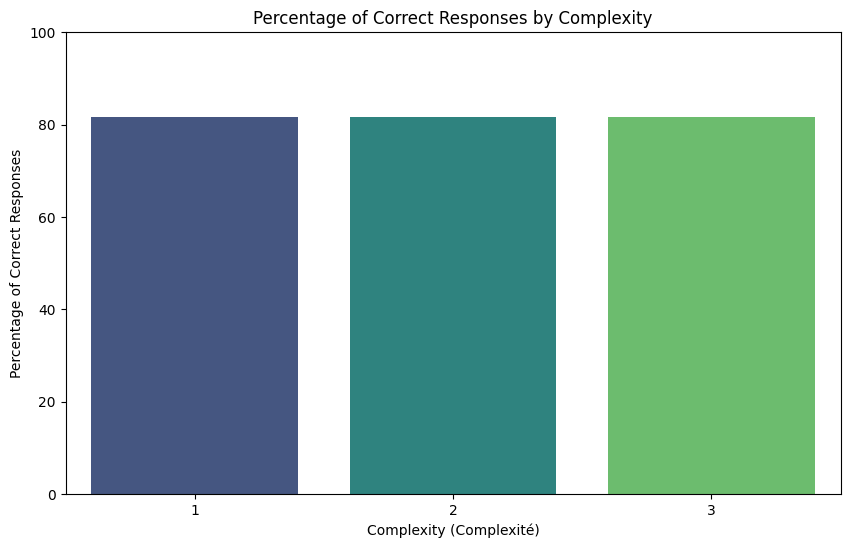

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the percentage of correct responses by 'Complexité'
score_by_complexity = evaluatorDF.groupby('Complexité')['ScoreInt'].mean().reset_index()
score_by_complexity['ScoreInt'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Complexité', y='ScoreInt', data=score_by_complexity, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.show()

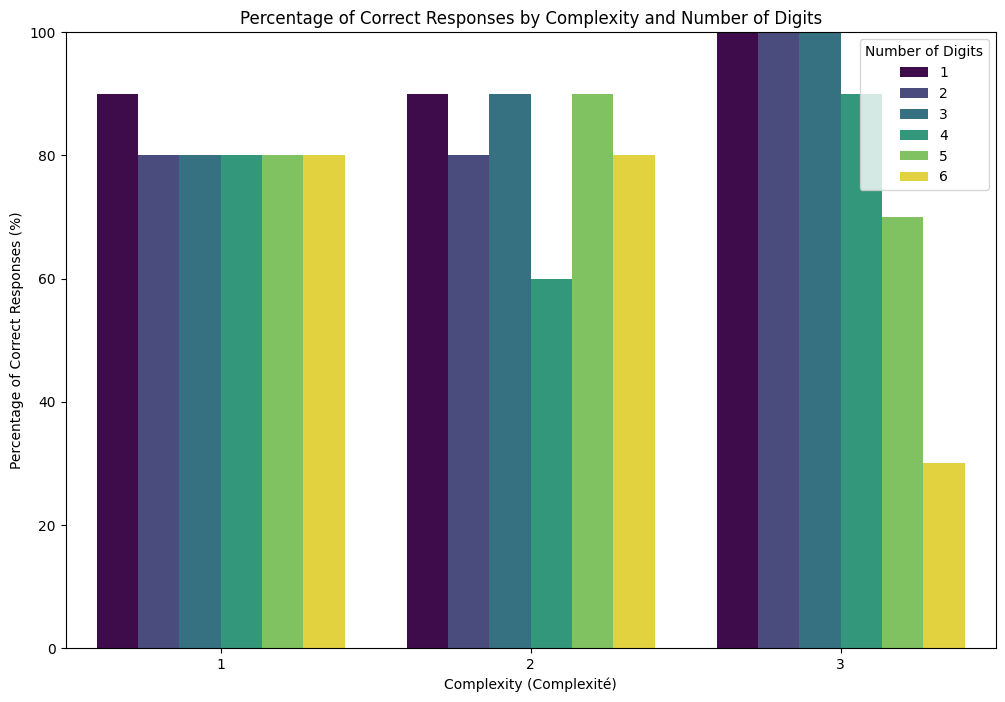

In [78]:
# Assuming evaluatorDF is your DataFrame and it has columns for 'Complexité', 'Nb digits', and 'Score3'
# Calculate the percentage of correct responses by 'Complexité' and 'Nb digits'
score_by_complexity_digits = evaluatorDF.groupby(['Complexité', 'Nb digits'])['ScoreInt'].mean().reset_index()
score_by_complexity_digits['ScoreInt'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Complexité', y='ScoreInt', hue='Nb digits', data=score_by_complexity_digits, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity and Number of Digits')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses (%)')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.legend(title='Number of Digits')
plt.show()

#### Score R0

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_27612\2209384277.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Complexité', y='ScoreR0', data=score_by_complexity, palette='viridis')


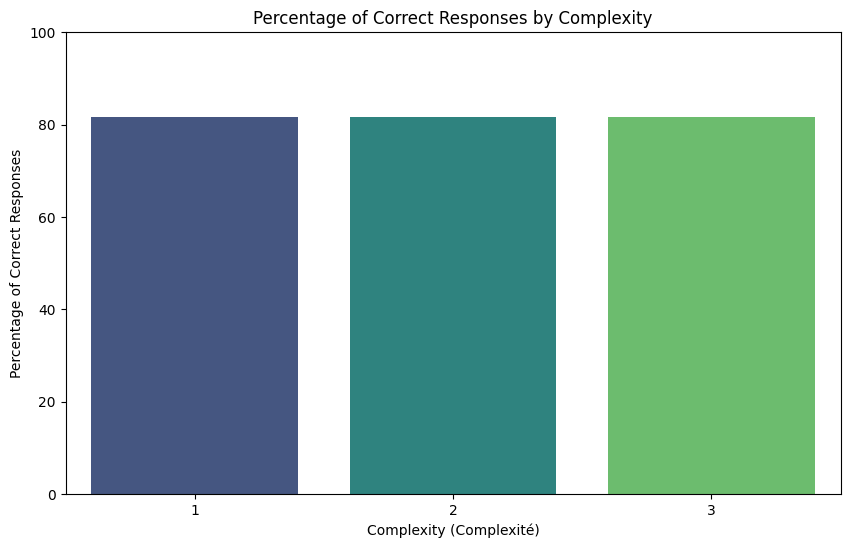

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the percentage of correct responses by 'Complexité'
score_by_complexity = evaluatorDF.groupby('Complexité')['ScoreR0'].mean().reset_index()
score_by_complexity['ScoreR0'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Complexité', y='ScoreR0', data=score_by_complexity, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.show()

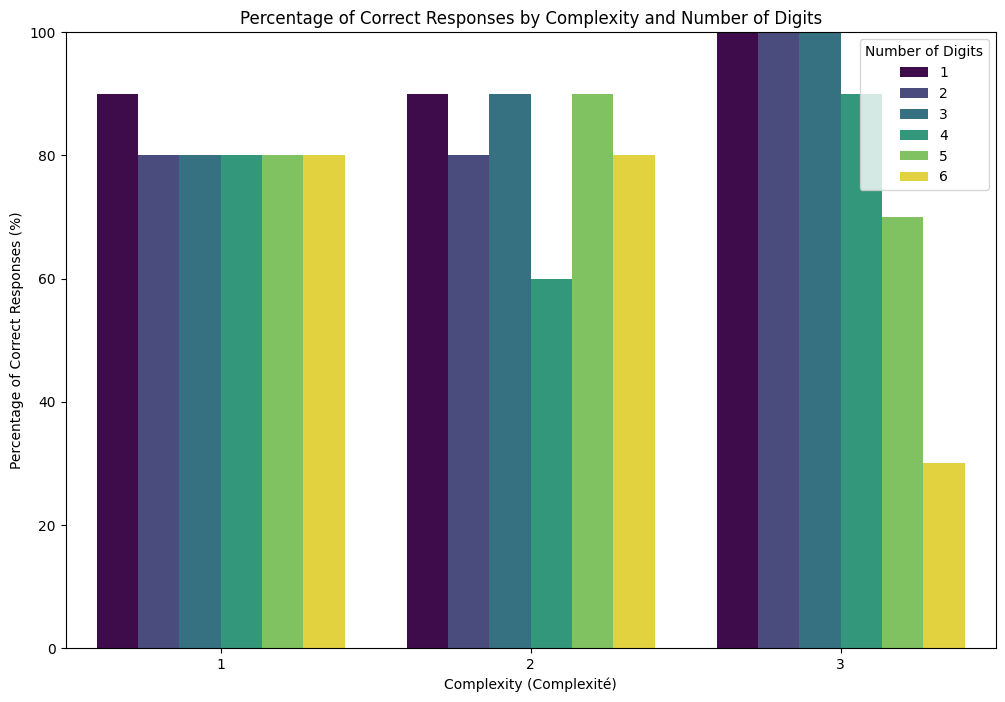

In [80]:
# Assuming evaluatorDF is your DataFrame and it has columns for 'Complexité', 'Nb digits', and 'Score3'
# Calculate the percentage of correct responses by 'Complexité' and 'Nb digits'
score_by_complexity_digits = evaluatorDF.groupby(['Complexité', 'Nb digits'])['ScoreR0'].mean().reset_index()
score_by_complexity_digits['ScoreR0'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Complexité', y='ScoreR0', hue='Nb digits', data=score_by_complexity_digits, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity and Number of Digits')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses (%)')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.legend(title='Number of Digits')
plt.show()